# EXPLORATORY DATA ANALYSIS

# Python packages

In [66]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *
from modules.sc_tools import *
import seaborn as sns
from collections import Counter
from MCML.modules import MCML, bMCML
from MCML import tools as tl
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import scvi
from rpy2.robjects import pandas2ri, r
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import anndata2ri
from rpy2.robjects import pandas2ri, numpy2ri, default_converter
from rpy2.robjects.conversion import localconverter

# R packages

In [2]:
pandas2ri.activate()
anndata2ri.activate()
# Install and load necessary R packages
#robjects.r('BiocManager::install("scran", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("scry", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("SingleCellExperiment", update=FALSE, force=TRUE)')
ro.r('library(scran)')
ro.r('library(BiocParallel)')
ro.r('library(scry)')
ro.r('library(SingleCellExperiment)')
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)
rcb.logger.setLevel(logging.ERROR)

/tmp/ipykernel_6733/416644494.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colW

# Import dataset

In [5]:
# Dictionary mapping sample tags to experimental group name
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
# Load count matrix and convert sample tags to experimental group name
adata = anndata.read_h5ad('data/fede_data/scdi_hypothalamus_count.h5ad')
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
# Load MapMyCells annotations and annotate adata object
anno_df = pd.read_csv("data/fede_data/scdi_hypothalamus_mapping.csv", skiprows=4)
adata = annotate_adata(adata, anno_df)

# Data analysis

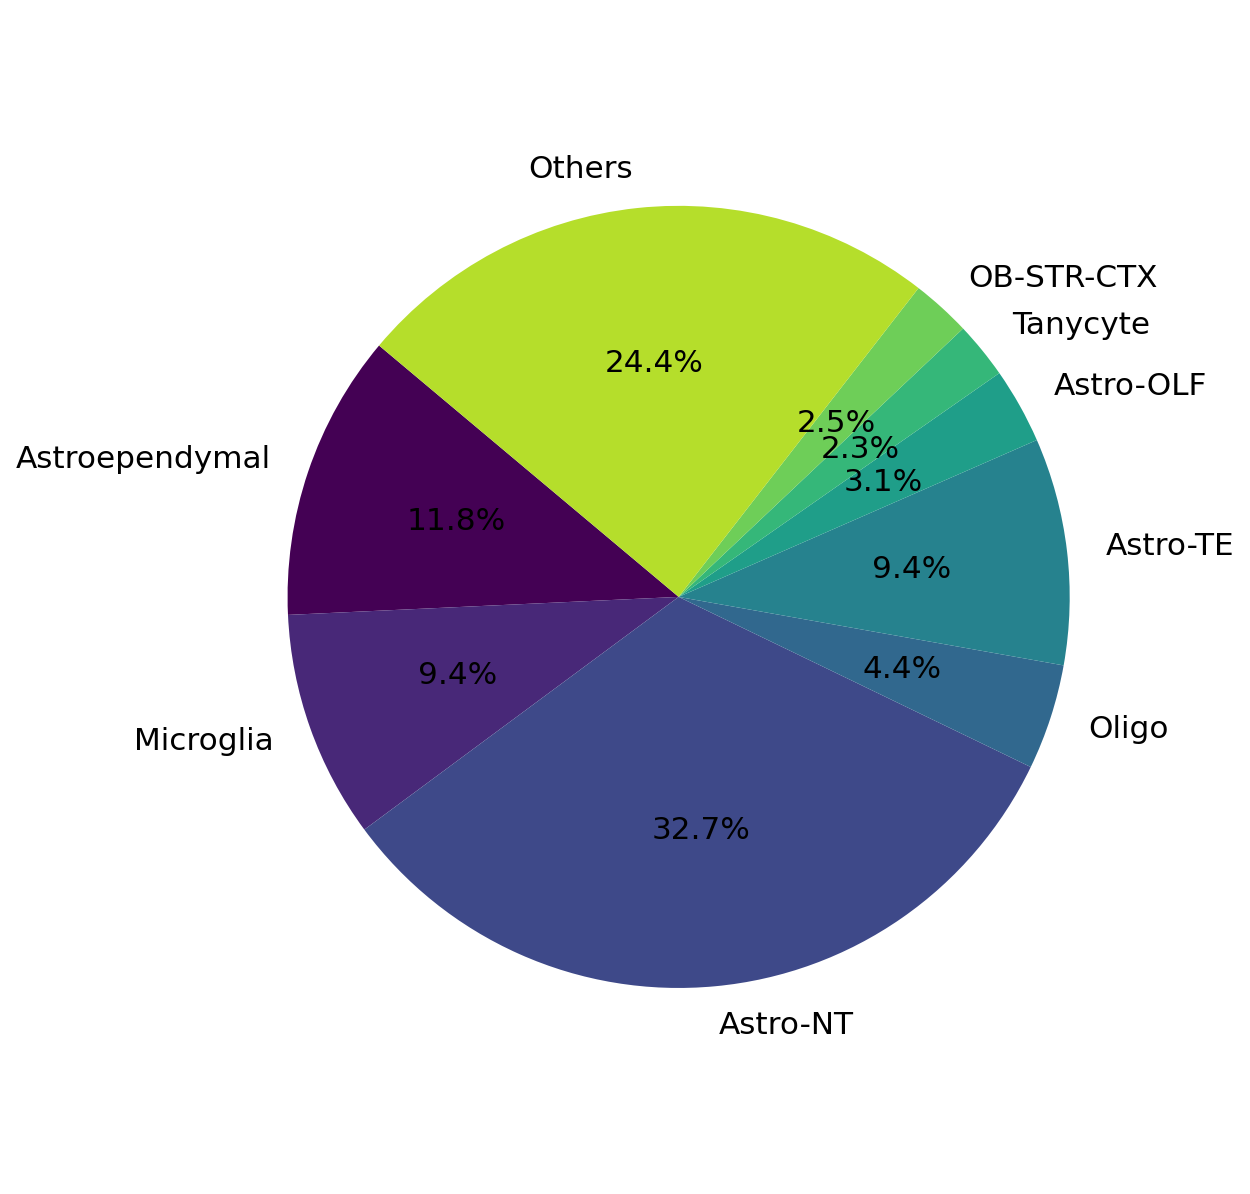

In [36]:
# Cells distribution by Sample Tag
pie_chart_condition(adata.obs['subclass_name'].values, min_pct=0.02, save_path='figures/pc_subclass.png')

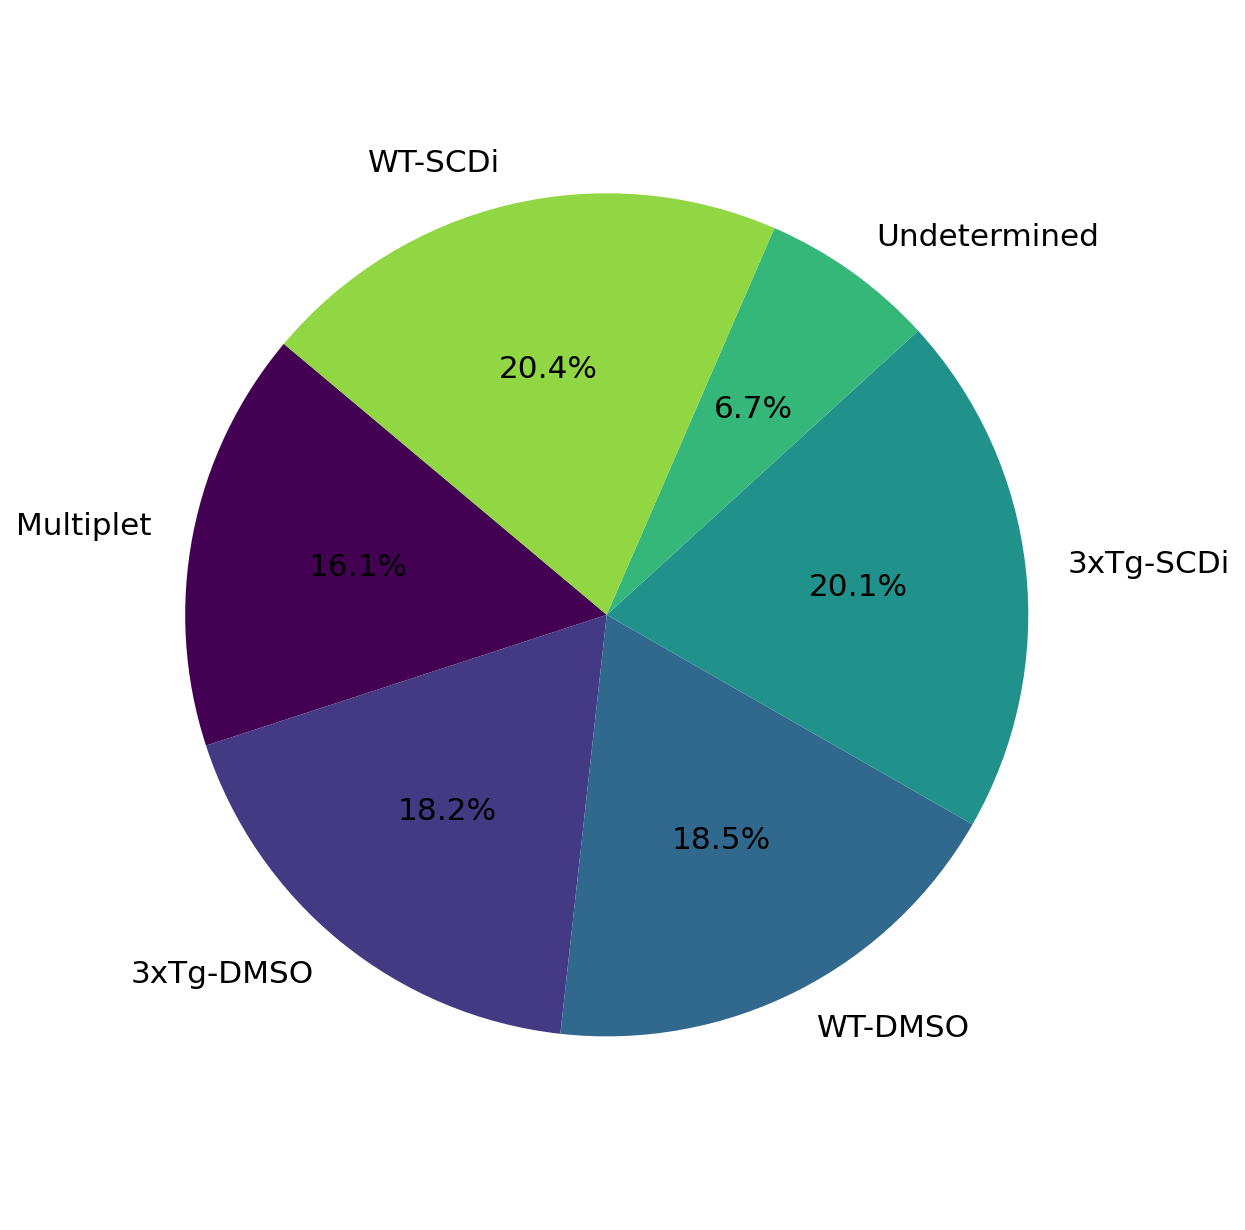

In [37]:
# Cells distribution by Sample Tag
pie_chart_condition(adata.obs['Sample_Tag'].values, save_path='figures/pc_condition.png')

In [40]:
# Compute QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Exclusion threshold for mitochondrial read %
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

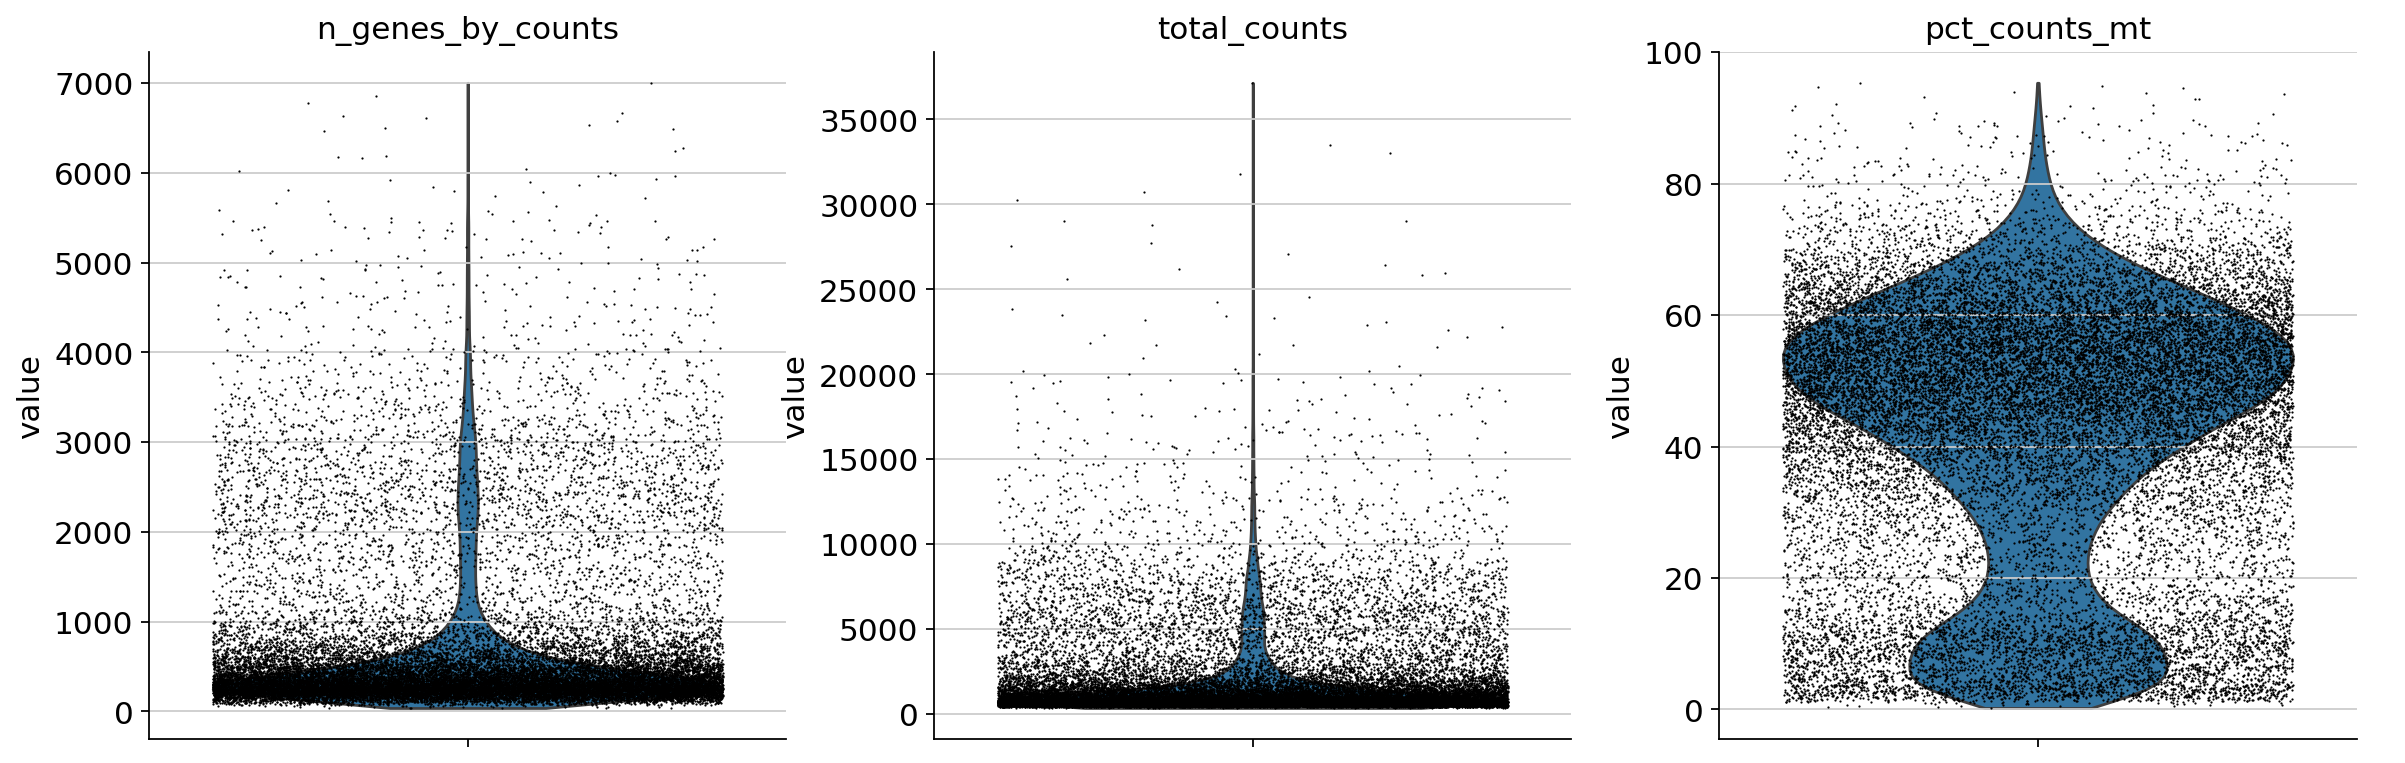

In [41]:
# Display QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

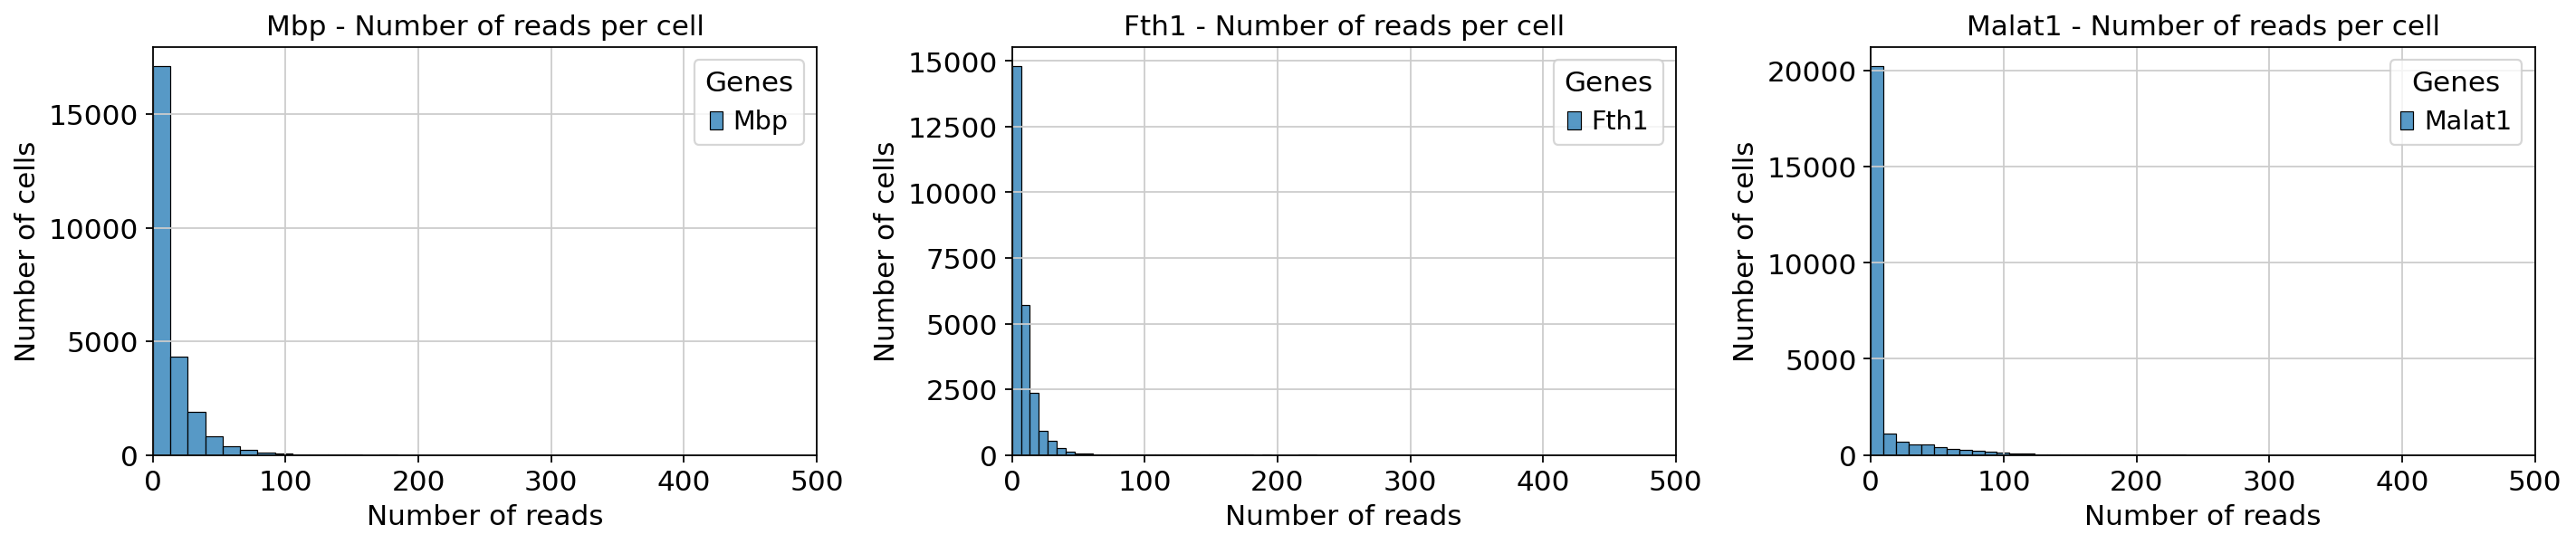

In [42]:
# Display read count distribution of top genes across cells
plot_top_n_distr(adata, top_n=3, save_path='figures/top_n_distr.png')

/home/client/projects/sc_alz/modules/visualize.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  mean = np.mean(data)


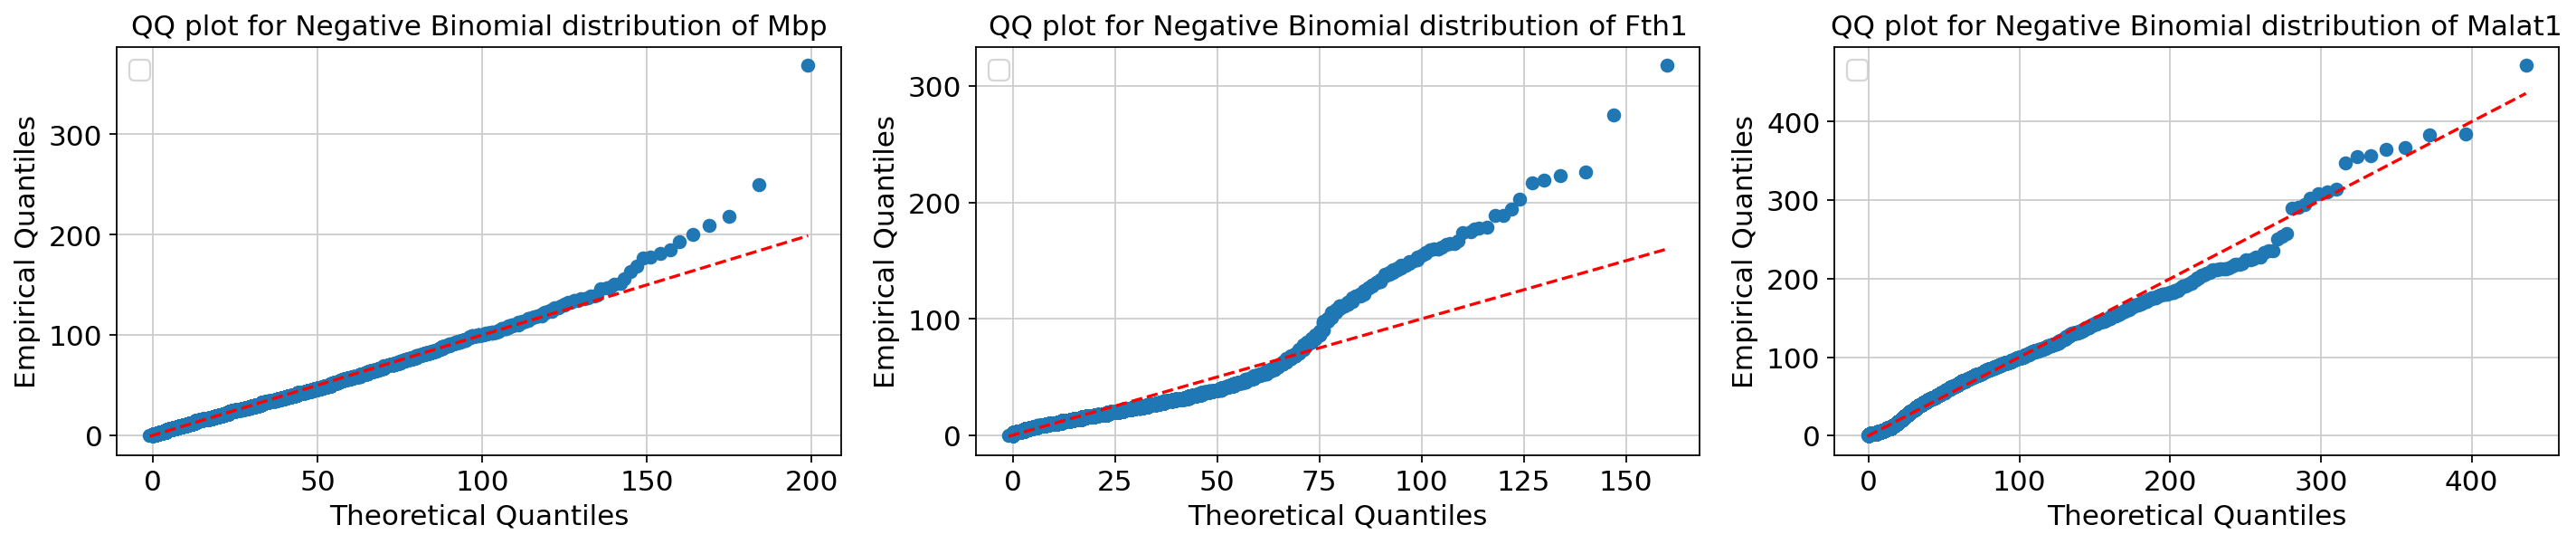

In [43]:
# Display QQ plot for negative binomial distribution
plot_top_genes_qq(adata, top_n=3, save_path='figures/top_n_qq.png')

# Quality control

In [44]:
# Filter out cells with less than N genes with non-zero value
sc.pp.filter_cells(adata, min_genes=150)

In [45]:
# Filter out genes appearing in less than N cells
sc.pp.filter_genes(adata, min_cells=3)

In [46]:
# Filter out high_mt cells
adata = adata[~adata.obs['high_mt'], :]
# Filter out multiplets
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

In [47]:
# Create a layer to store raw counts
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_6733/2024546370.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


# Normalization

### Shifted logarithm

In [62]:
# Perform transformation and store in the log1p_norm layer
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

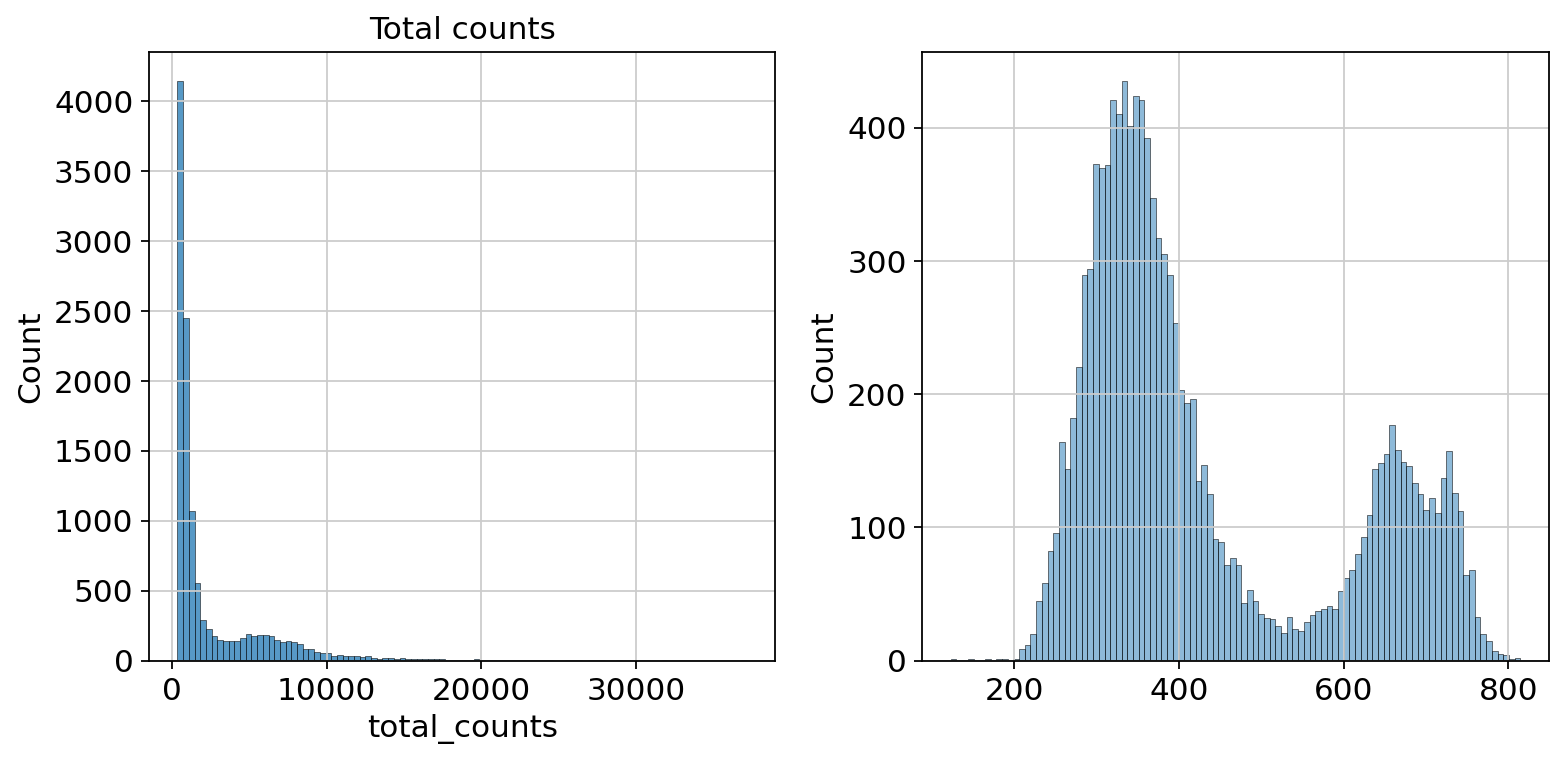

In [71]:
display_transformation(adata, 'log1p_norm', save_path='figures/shifted_log_distr.png')

### Scran normalization

In [74]:
# Perform transformation and store in the scran_normalization layer
adata = scran_normalization(adata)

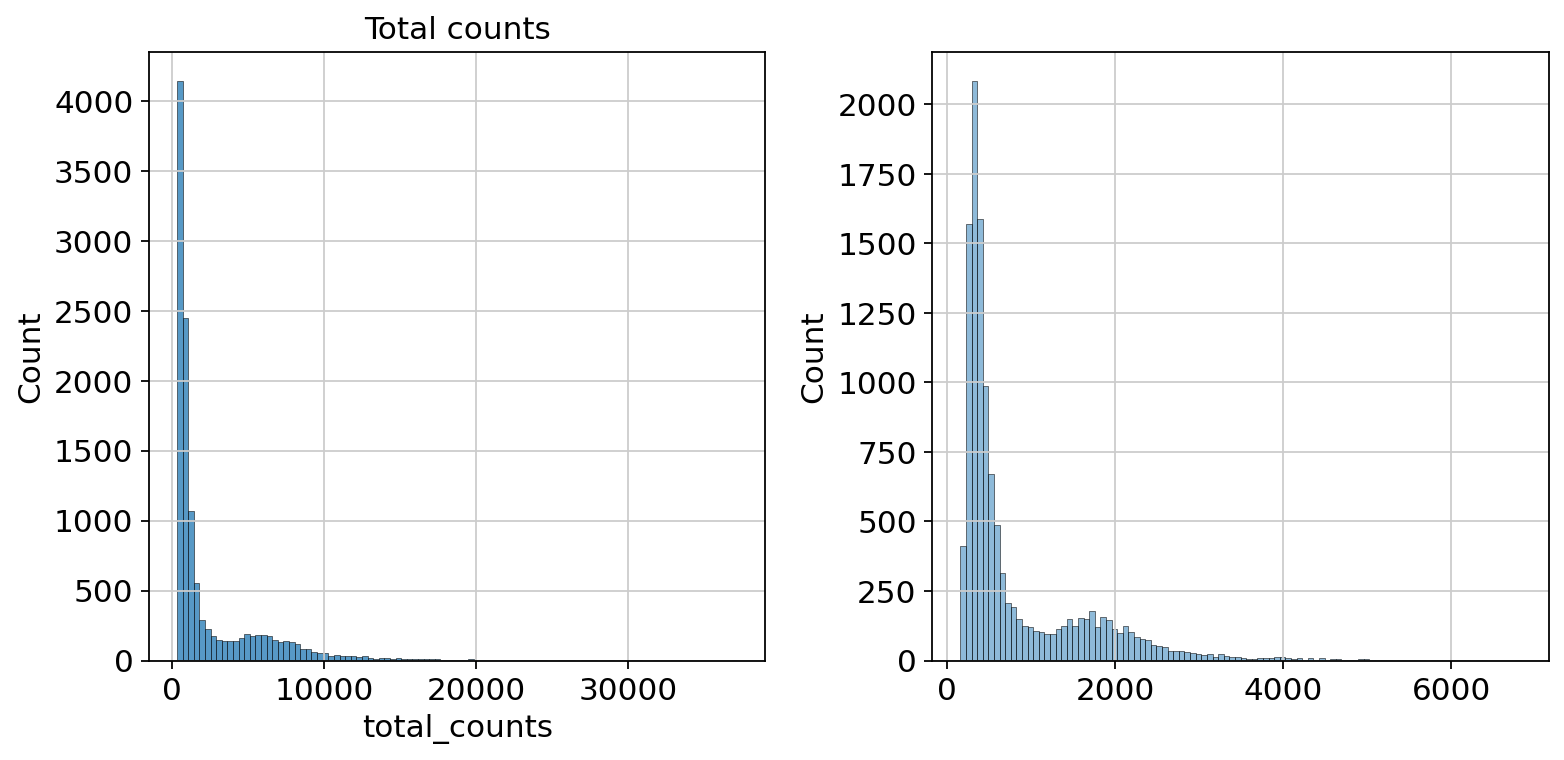

In [75]:
display_transformation(adata, 'scran_normalization', save_path='figures/scran_distr.png')

### Pearson residuals

In [78]:
# Perform transformation and store in the analytic_pearson_residuals layer
adata = pearson_normalization(adata)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:68: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


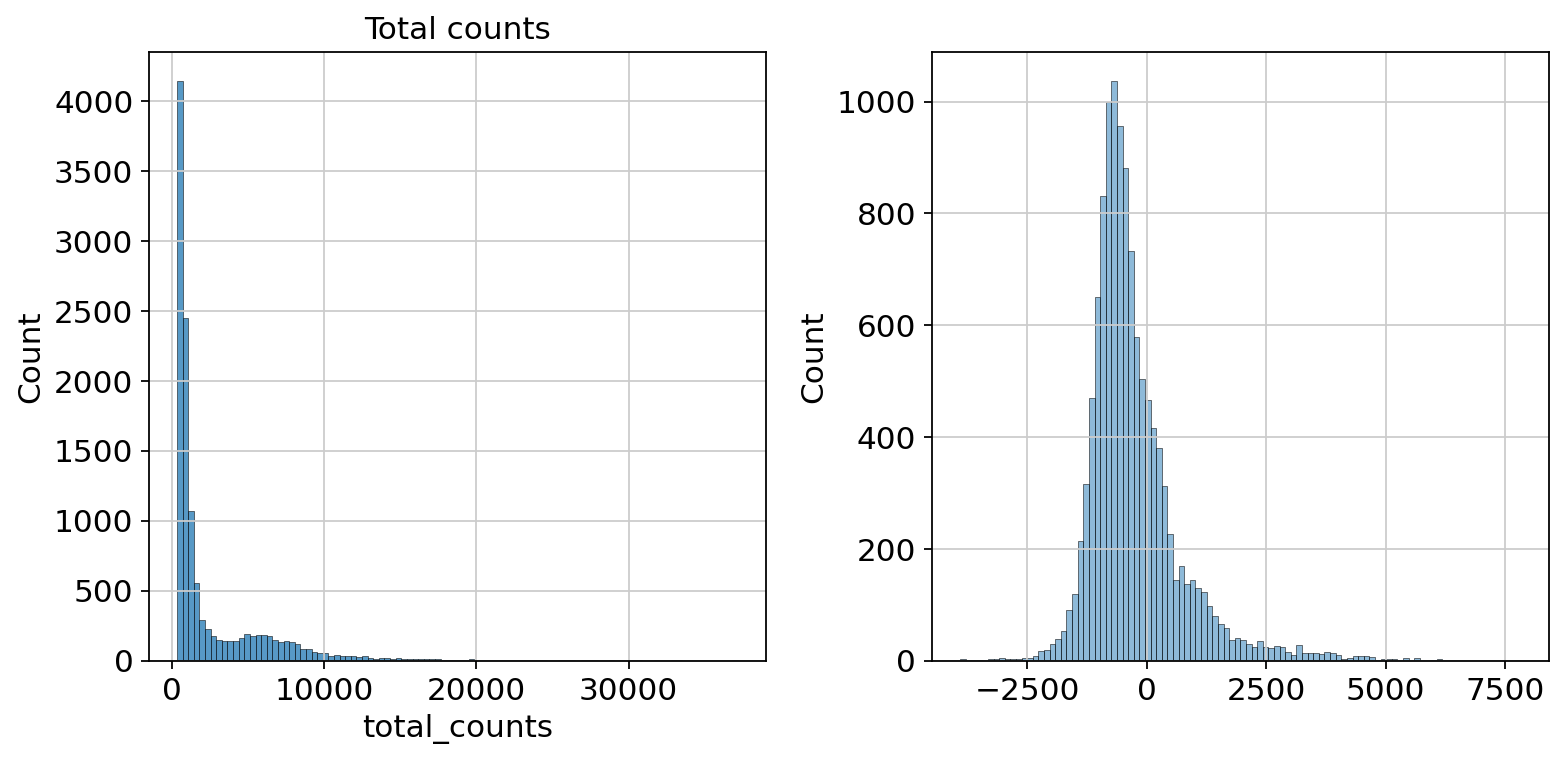

In [79]:
display_transformation(adata, 'analytic_pearson_residuals', save_path='figures/pearson_distr.png')

# Save/Load adata object

In [80]:
# Write data to specified path
adata.write("data/fede_data/scdi_hypothalamus_normalized.h5ad")

In [82]:
# Load data from specified path
adata = sc.read(
    filename="data/fede_data/scdi_hypothalamus_normalized.h5ad"
)

# Select features

In [84]:
adata = select_features(adata)

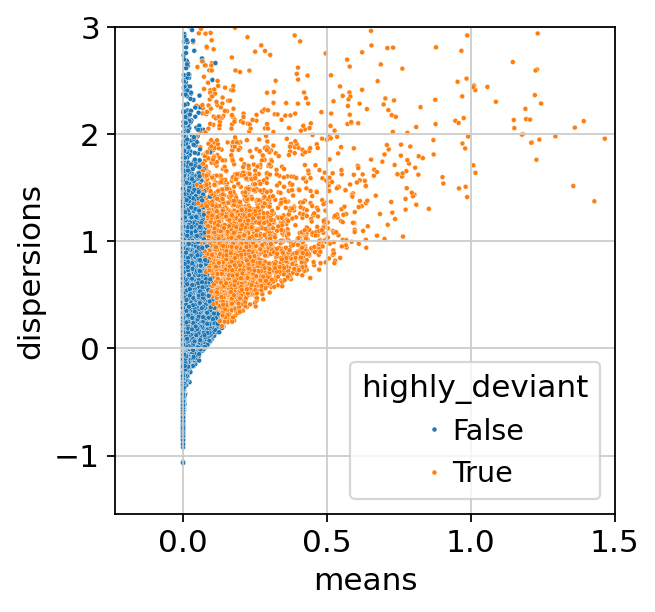

In [86]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False, layer='scran_normalization')
ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.savefig('figures/scran_highly_deviant.png')
plt.show()

In [87]:
adata.var["highly_variable"] = adata.var["highly_deviant"]

# Dimensionality reduction

## Principal component analysis (PCA)

In [97]:
# Compute explained variance for first few PCs
show_pc_variance(adata, 'log1p_norm', pc_list=[10,20,50,100])
show_pc_variance(adata, 'scran_normalization', pc_list=[10,20,50,100])
show_pc_variance(adata, 'analytic_pearson_residuals', pc_list=[10,20,50,100])

log1p_norm explained variance  for the first 10 PCs:0.224844483211716
log1p_norm explained variance  for the first 20 PCs:0.251046928016038
log1p_norm explained variance  for the first 50 PCs:0.29715069733017196
log1p_norm explained variance  for the first 100 PCs:0.34809112946667414


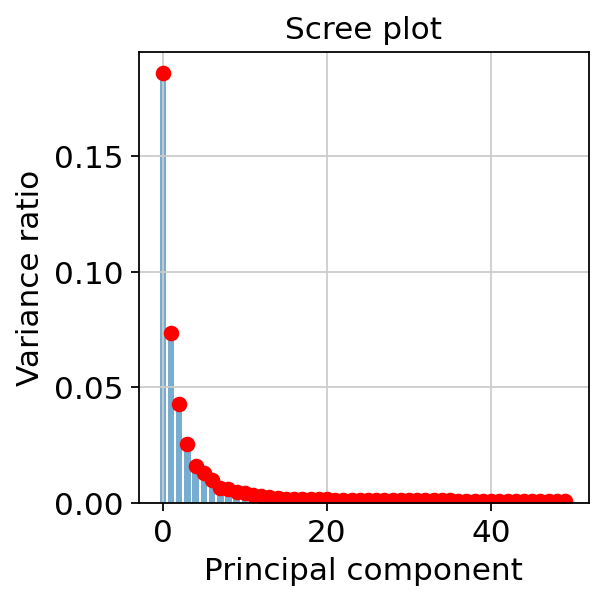

In [100]:
# Display scree plot
scree_plot(adata, layer='scran_normalization', save_path='figures/scree_plot.png')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


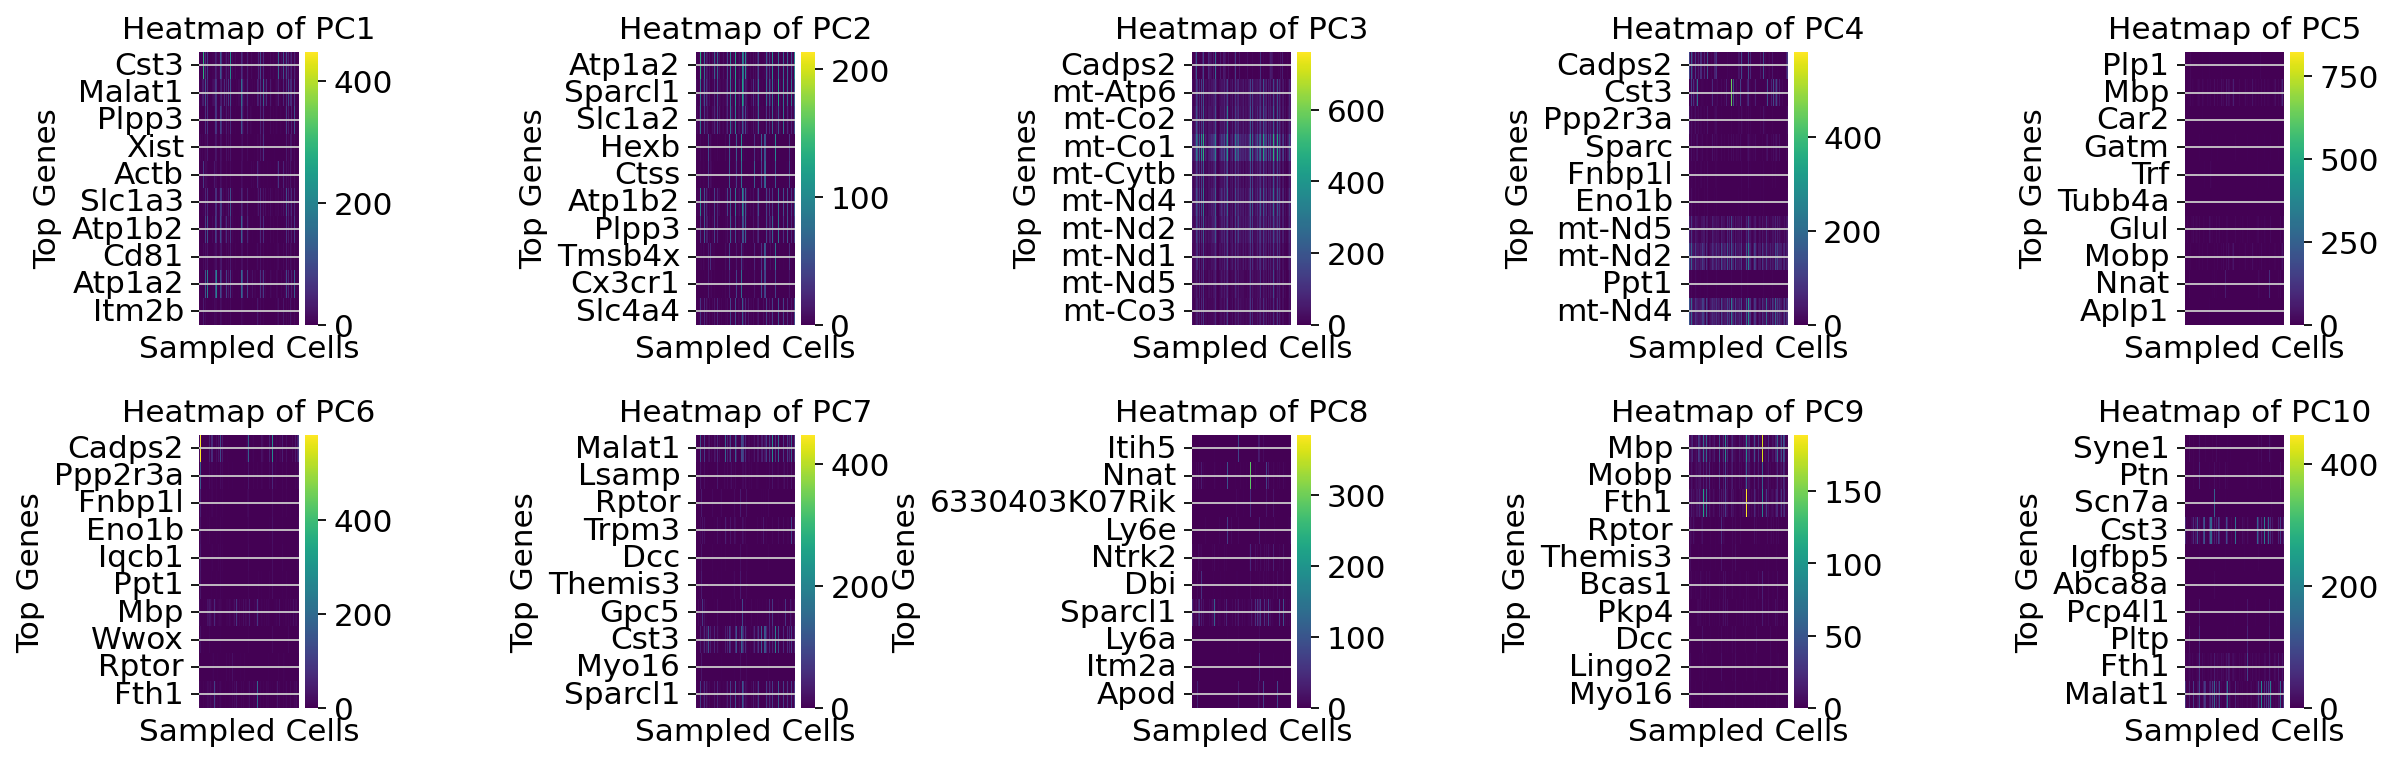

In [105]:
# PCA gene heatmap - Genes most associated to each PC
plot_top_genes_pca_heatmaps(adata, layer='scran_normalization', n_cells=500, n_top_genes=10, pc_index='10m', n_comps=10, random_seed=42, save_path='figures/pca_gene_heatmap.png')

In [106]:
# Reduce to N dimensions with PCA
sc.tl.pca(adata, n_comps=10, use_highly_variable=True, layer='scran_normalization')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


### Optional - Batch correction

In [ ]:
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

## Multi-class multi-label (MCML)

In [107]:
adata_mcml = adata[:, adata.var["highly_variable"]].copy()

In [108]:
subclass_name = adata_mcml.obs['subclass_name'].values.tolist()
sample_tag = adata_mcml.obs['Sample_Tag'].values.tolist()

In [109]:
# mcml = MCML(n_latent = 10, epochs = 100)
# latentMCML = mcml.trainTest(adata_mcml.layers['log1p_norm'].toarray(), np.array([subclass_name]), fracNCA = 0.8, silent = True)
# mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname='figures/mcml_test.png')

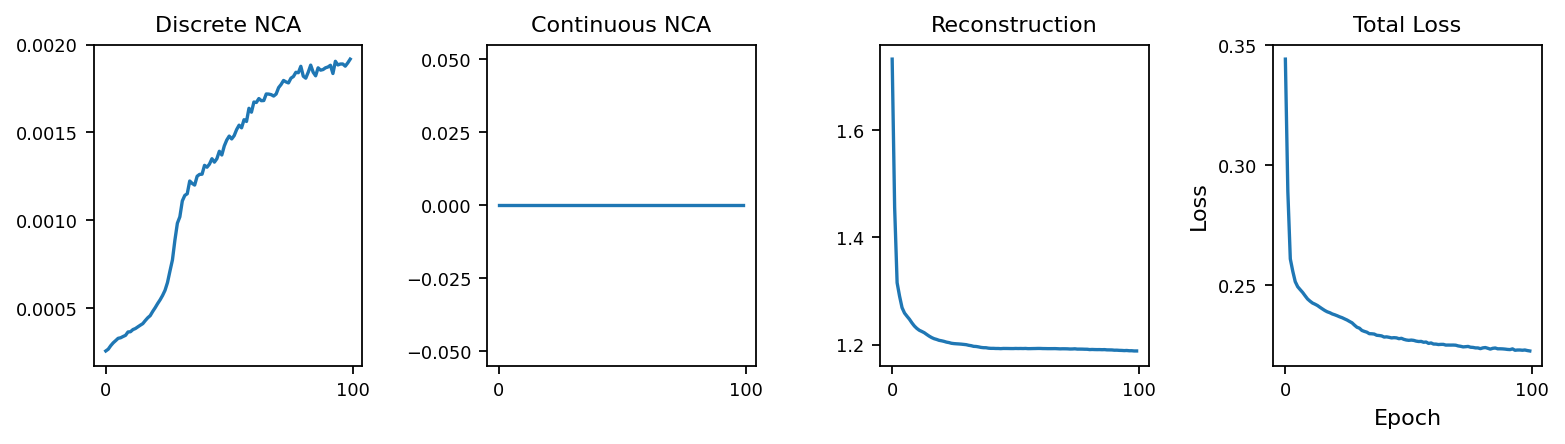

In [110]:
mcml = MCML(n_latent = 10, epochs = 100)
latentMCML = mcml.fit(adata_mcml.layers['log1p_norm'].toarray(), np.array([subclass_name]), fracNCA = 0.8, silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname='figures/mcml_train.png')

In [111]:
adata.obsm['X_mcml'] = latentMCML

## scVI

In [115]:
adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="Sample_Tag")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
model_scvi.train(max_epochs=max_epochs_scvi)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████████████████████████████████| 400/400 [02:48<00:00,  2.37it/s, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.9e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████| 400/400 [02:48<00:00,  2.37it/s, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.9e+3]


# Save/Load adata object

In [116]:
# Write data to specified path
adata.write("data/fede_data/scdi_hypothalamus_reduced.h5ad")

In [117]:
# Load data from specified path
adata = sc.read(
    filename="data/fede_data/scdi_hypothalamus_reduced.h5ad"
)

# Clustering

In [147]:
# Compute cell graph and run leiden clustering algorithm
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.leiden(adata, resolution=0.5)

In [148]:
# Replace cluster id by the cell name most representative of that cluster
assign_unique_cell_type_names(adata, cluster_key='leiden', cluster_types=['class_name', 'subclass_name', 'supertype_name'])

# Visualization

In [149]:
# Compute 2D UMAP
sc.tl.umap(adata)

### Leiden cluster visualization

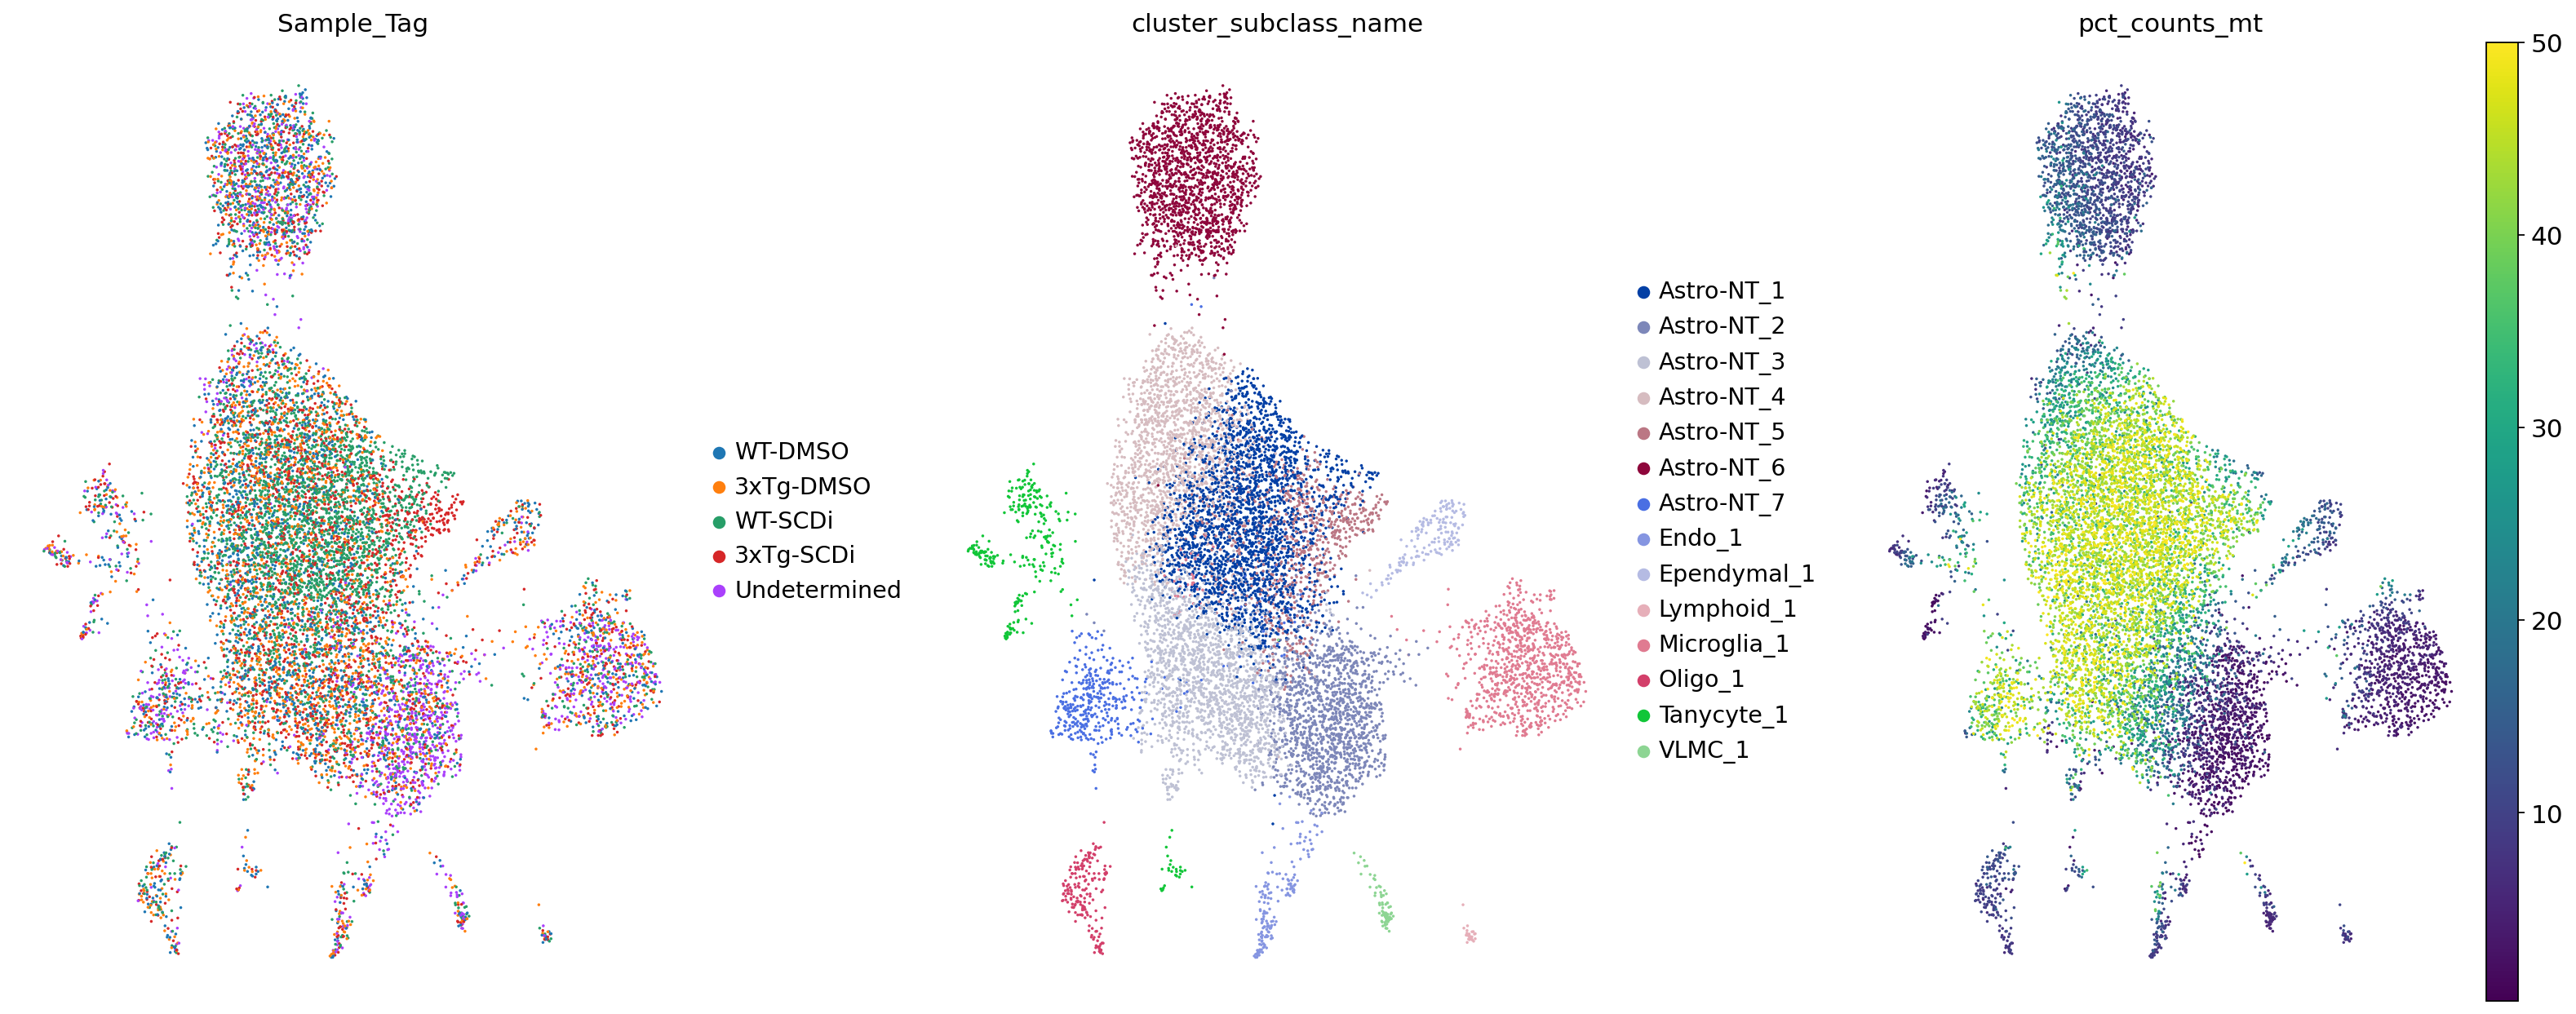

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
sc.pl.umap(adata, color='Sample_Tag', ax=axs[0], show=False)
sc.pl.umap(adata, color='cluster_subclass_name', ax=axs[1], show=False)
sc.pl.umap(adata, color='pct_counts_mt', ax=axs[2], show=False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
plt.savefig('figures/umap_leiden.png', bbox_inches='tight')
plt.show()

### Cell type visualization by experimental group

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_l

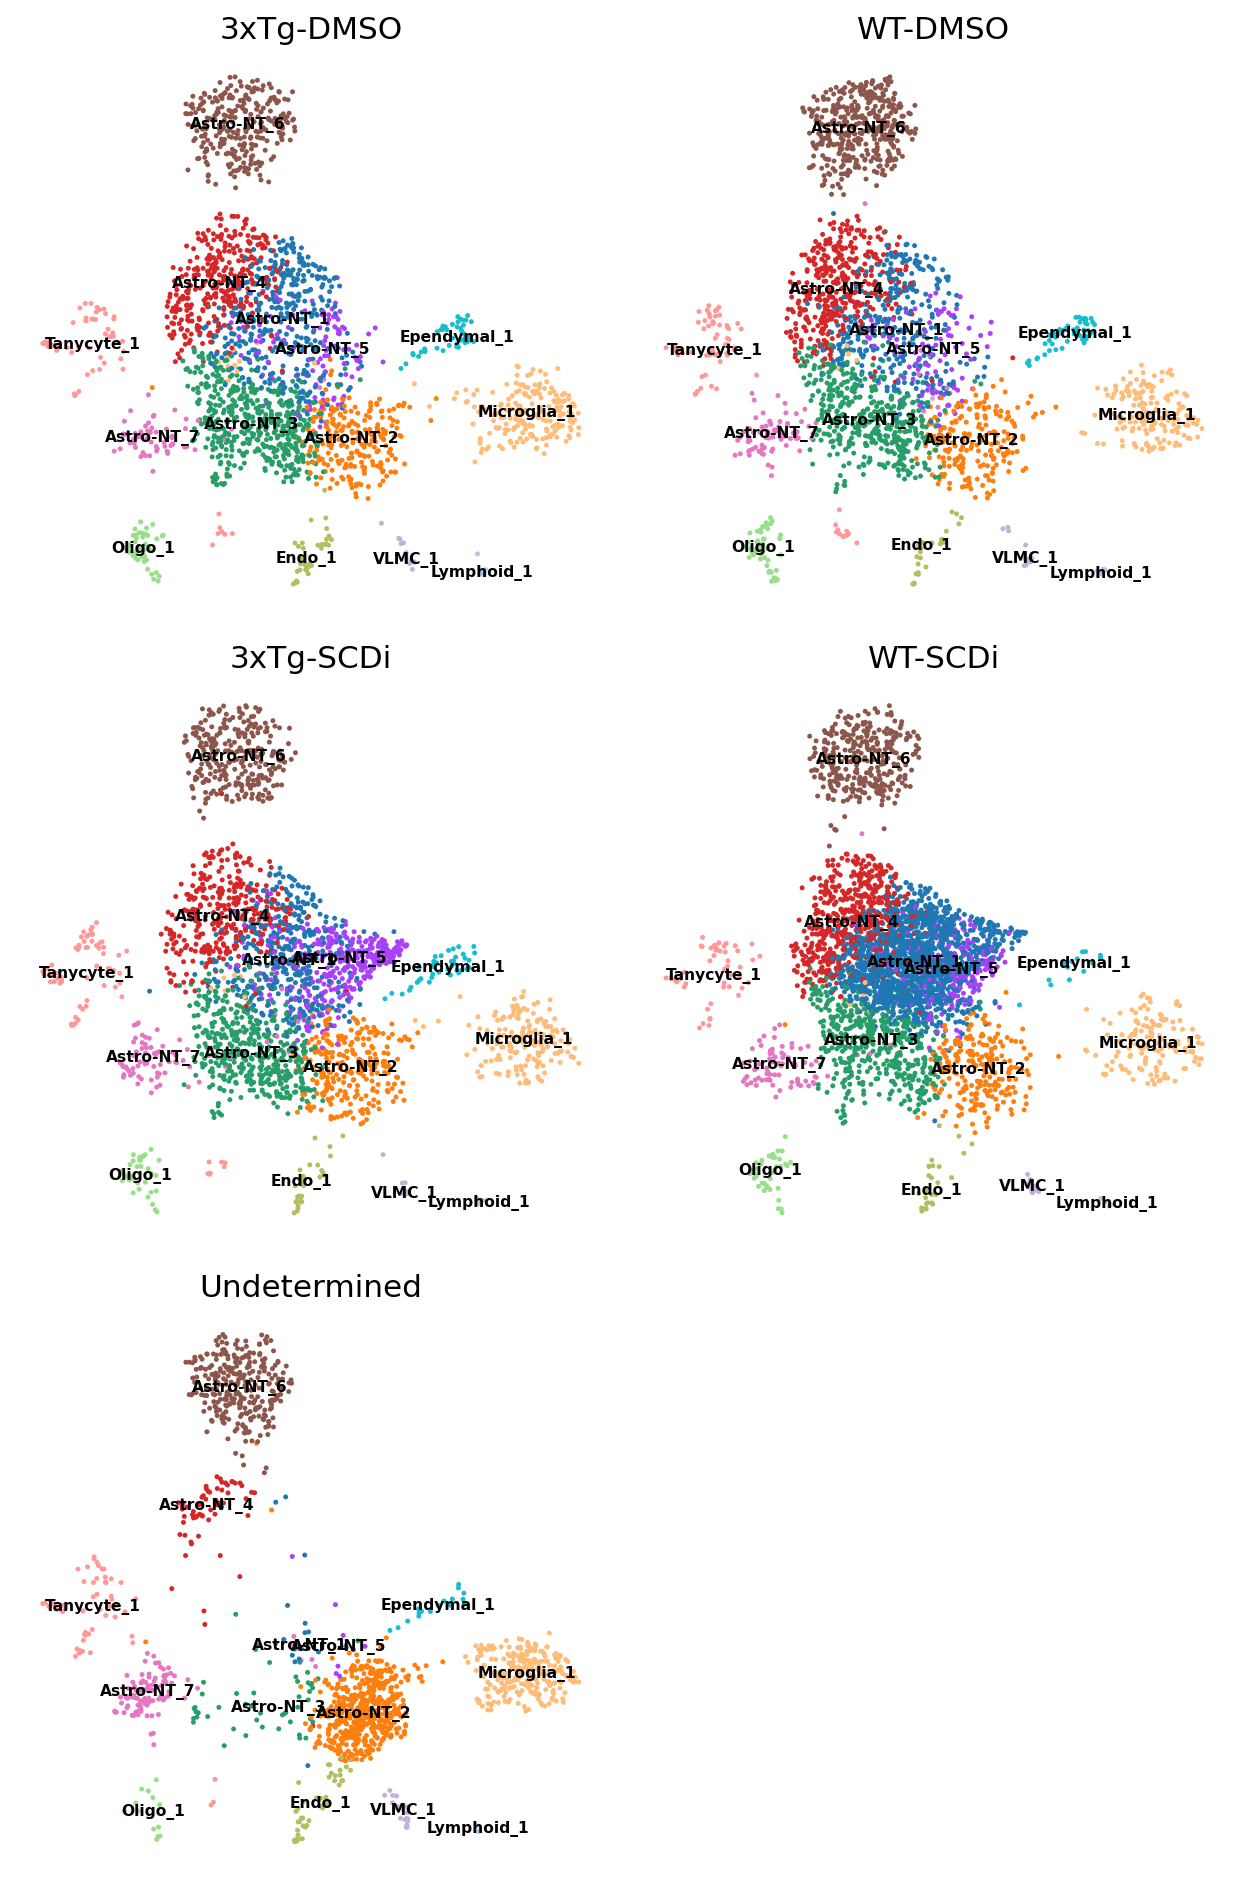

In [151]:
plot_umap(adata, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

# Cluster homogeneity analysis

In [152]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

/home/client/projects/sc_alz/modules/visualize.py:344: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  - class_level (str): Column name in the adata.obs DataFrame representing the cell type class.


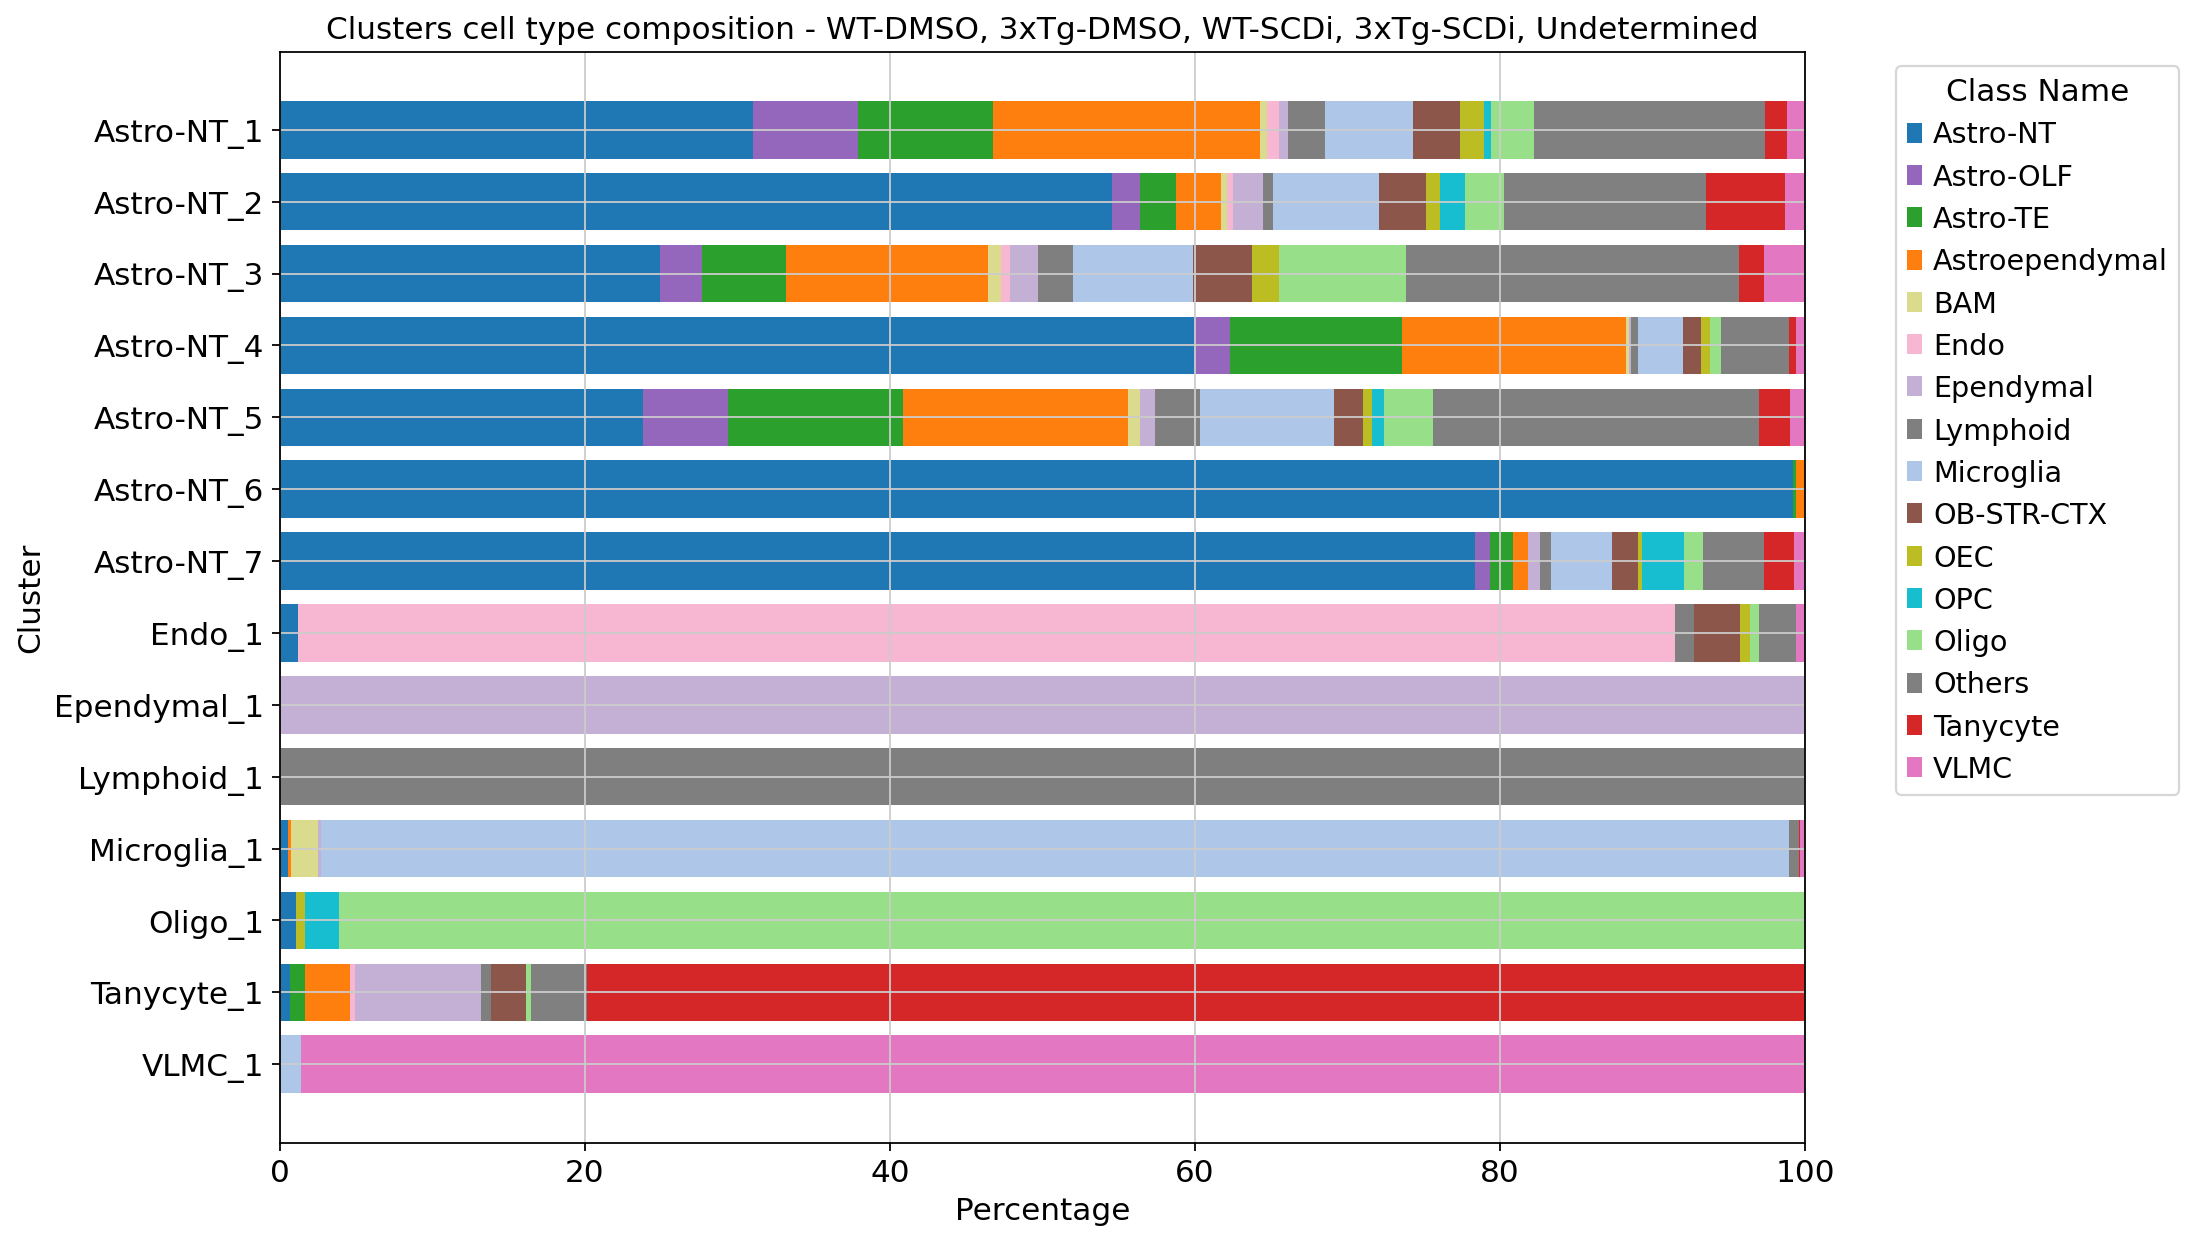

In [153]:
create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=50, save_path='figures/all_ditto.png')

# Evaluating embedding quality

In [135]:
# Calculate the fraction of neighbors for each cell that have the same label as the cell itself.
# Also returns the labels of the neighbors for each embedding method.
subclass_name = adata_mcml.obs['subclass_name'].values.tolist()
sample_tag = adata_mcml.obs['Sample_Tag'].values.tolist()
# PCA
pca_neighbor_fracs, pca_labels = tl.frac_unique_neighbors(
    adata.obsm['X_pca'], np.array(subclass_name), metric=1, neighbors=30
)

# scVI
scvi_neighbor_fracs, scvi_labels = tl.frac_unique_neighbors(
    adata.obsm['X_scVI'], np.array(subclass_name), metric=1, neighbors=30
)

# MCML
mcml_neighbor_fracs, mcml_labels = tl.frac_unique_neighbors(
    adata.obsm['X_mcml'], np.array(subclass_name), metric=1, neighbors=30
)

# Identify the most common cell types
common_cell_types = [x[0] for x in Counter(adata.obs['subclass_name']).most_common(15)]

# Filter fractions to include only the most common cell types and calculate the mean for each type
pca_neighbor_fracs = {x: np.mean(y) for x, y in pca_neighbor_fracs.items() if x in common_cell_types}
scvi_neighbor_fracs = {x: np.mean(y) for x, y in scvi_neighbor_fracs.items() if x in common_cell_types}
mcml_neighbor_fracs = {x: np.mean(y) for x, y in mcml_neighbor_fracs.items() if x in common_cell_types}

# Combine the results into a single DataFrame
combined_df = pd.DataFrame({
    'PCA': pca_neighbor_fracs,
    'MCML': mcml_neighbor_fracs,
    'scVI': scvi_neighbor_fracs
}).T


In [136]:
output_path = "figures/combined_cell_type_data.xlsx"
combined_df.to_excel(output_path)

In [139]:
combined_df.T

PCA      MCML      scVI
Astro-NT        0.723201  0.879656  0.702111
Astro-OLF       0.113353  0.631579  0.098635
Astro-TE        0.144874  0.770840  0.145904
Astroependymal  0.200656  0.838402  0.203011
BAM             0.069006  0.071930  0.092982
Endo            0.563799  0.833513  0.739247
Ependymal       0.640332  0.934045  0.685172
Lymphoid        0.140942  0.349819  0.227174
Microglia       0.680389  0.792142  0.682811
OB-STR-CTX      0.075672  0.140323  0.067339
OEC             0.050000  0.063462  0.051282
OPC             0.063690  0.177381  0.111905
Oligo           0.447956  0.659390  0.453777
Tanycyte        0.584295  0.836458  0.583734
VLMC            0.285374  0.456293  0.386395

# Dump data

In [ ]:
adata.write("data/fede_count_clustered.h5ad")